In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Cluster_Photometry.csv')

star_ids = data['star'].unique()
altitudes = data['alt_deg'].unique()
magnitudes = data['inst_mag'].unique()
del_mags = data['del_mag'].unique()

print("Star IDs:", star_ids.tolist())
print("Altitudes:", altitudes.tolist())
print("Magnitudes:", magnitudes.tolist())
print("Delta Magnitudes:", del_mags.tolist())

Star IDs: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
Altitudes: [35.94584186999935, 35.95575379166827, 35.96974741789223, 35.98418134870365, 35.975608906022565, 35.993996348789985, 36.0065606319981, 36.01547213391924, 35.97306722980136, 36.1272818681545, 36.137184516777694, 36.15115432282408, 36.16555225069875, 36.15694197428984, 36.17541316013956, 36.18804523103187, 36.19703317458358, 36.15430739946127, 36.31180800309922, 36.32170115764679, 36.335646646847934, 36.35000786260616, 36.34135915496904, 36.35991541013213, 36.37261635676358, 36.3816820015504, 36.338630098890576, 35.50311705564894, 35.513051346711734, 35.52710272517281, 35.54162411516475, 35.533144183176624, 35.551326873206136, 35.5637254741062, 35.57245027577446, 35.53082918946036, 35.767483635970784, 35.7774046132834, 35.79142156876721, 35.80589079994336, 35.79735559301244, 35.8156606197988, 35.82815820335132, 35.83699452157508, 35.79490523738508, 40.0755033746788, 40.08518840978291, 40.098616534315056, 40.11220584580733

In [20]:
class Star:
    def __init__(self, star_id):
        self.star_id = star_id
        self.altitudes = {'u' : [], 'g': [], 'r': [], 'i': [], 'z': []}
        self.magnitudes = {'u' : [], 'g': [], 'r': [], 'i': [], 'z': []}
        self.del_mags = {'u' : [], 'g': [], 'r': [], 'i': [], 'z': []}

    def add_observation(self, band ,altitude, magnitude, del_mag):
        self.altitudes[band].append(altitude)
        self.magnitudes[band].append(magnitude)
        self.del_mags[band].append(del_mag)

    def generate_air_mass(self):
        self.air_masses = {band: [1/np.sin(np.radians(alt)) for alt in alts] for band, alts in self.altitudes.items()}

stars = []
for _, row in data.iterrows():
    if row['star'] not in [star.star_id for star in stars]:
        star = Star(row['star'])
        stars.append(star)
    
    star = next(star for star in stars if star.star_id == row['star'])
    star.add_observation(row['filter'], float(row['alt_deg']), float(row['inst_mag']), float(row['del_mag']))
for star in stars:
    star.generate_air_mass()

# for star in stars:
#     print(f"Star ID: {star.star_id}")
#     print(f"Altitudes: {star.altitudes}")
#     print(f"Air Masses: {star.air_masses}")
#     print(f"Magnitudes: {star.magnitudes}")
#     print(f"Delta Magnitudes: {star.del_mags}")
#     print()

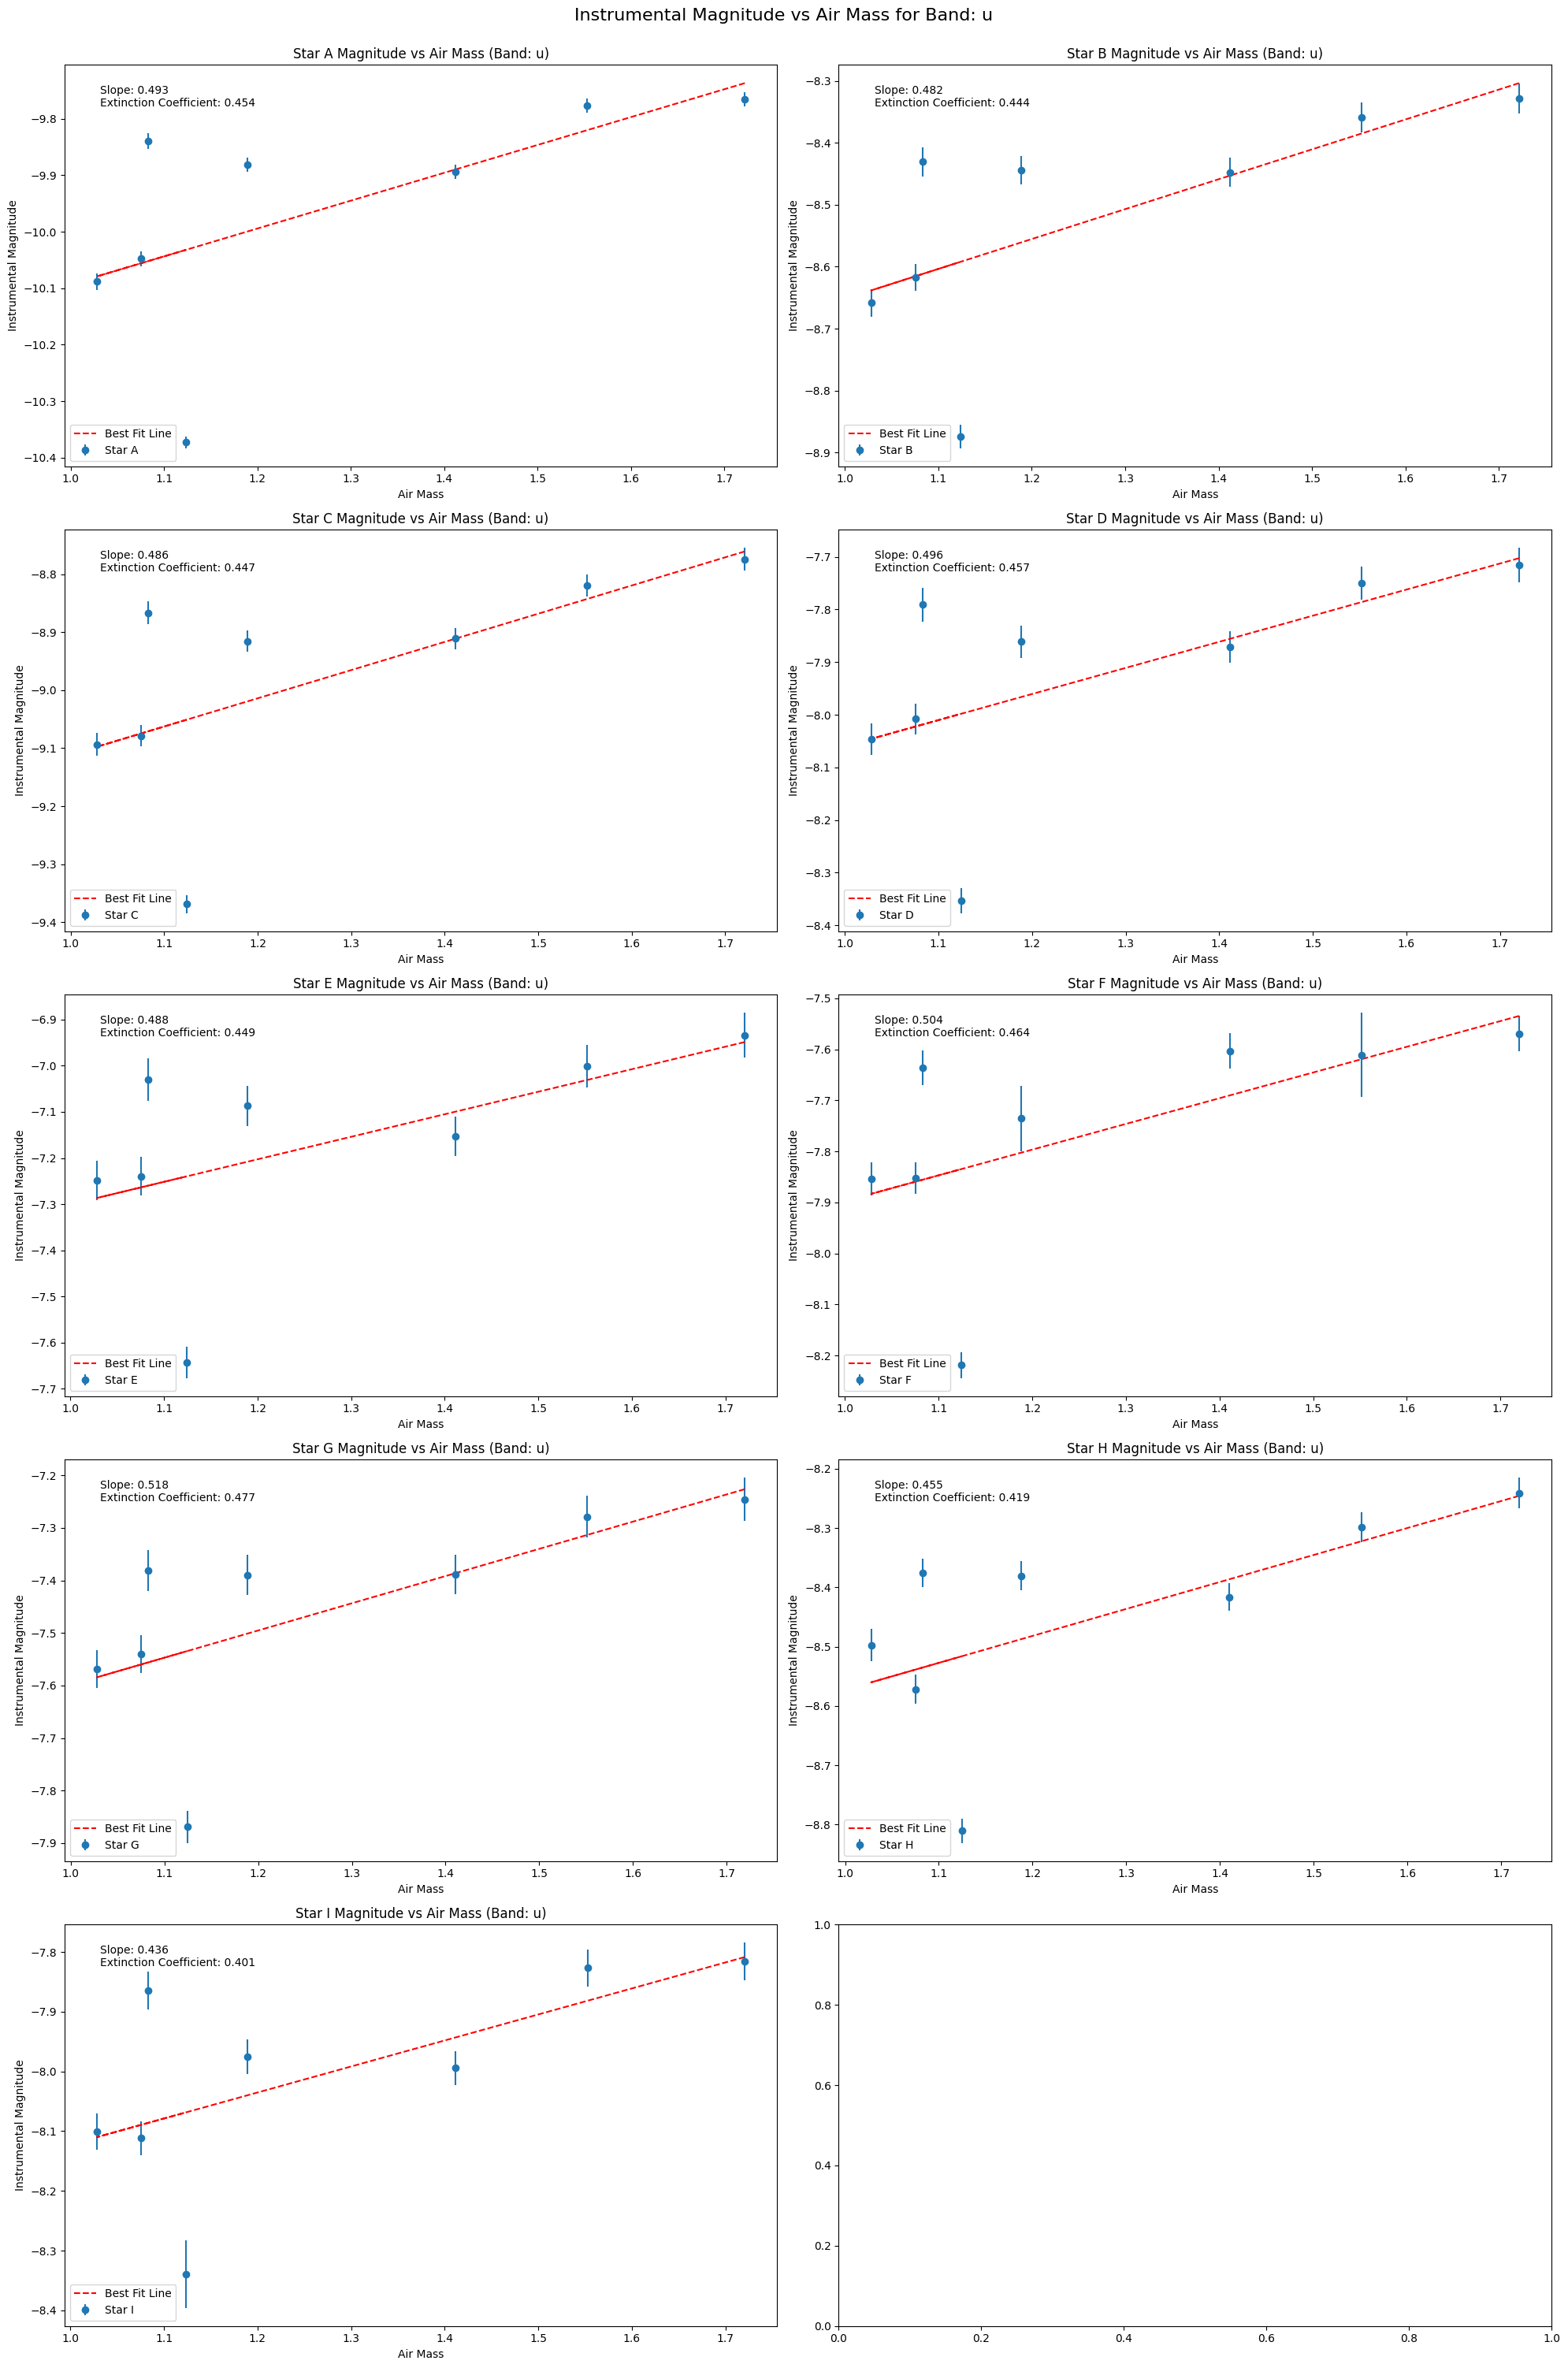

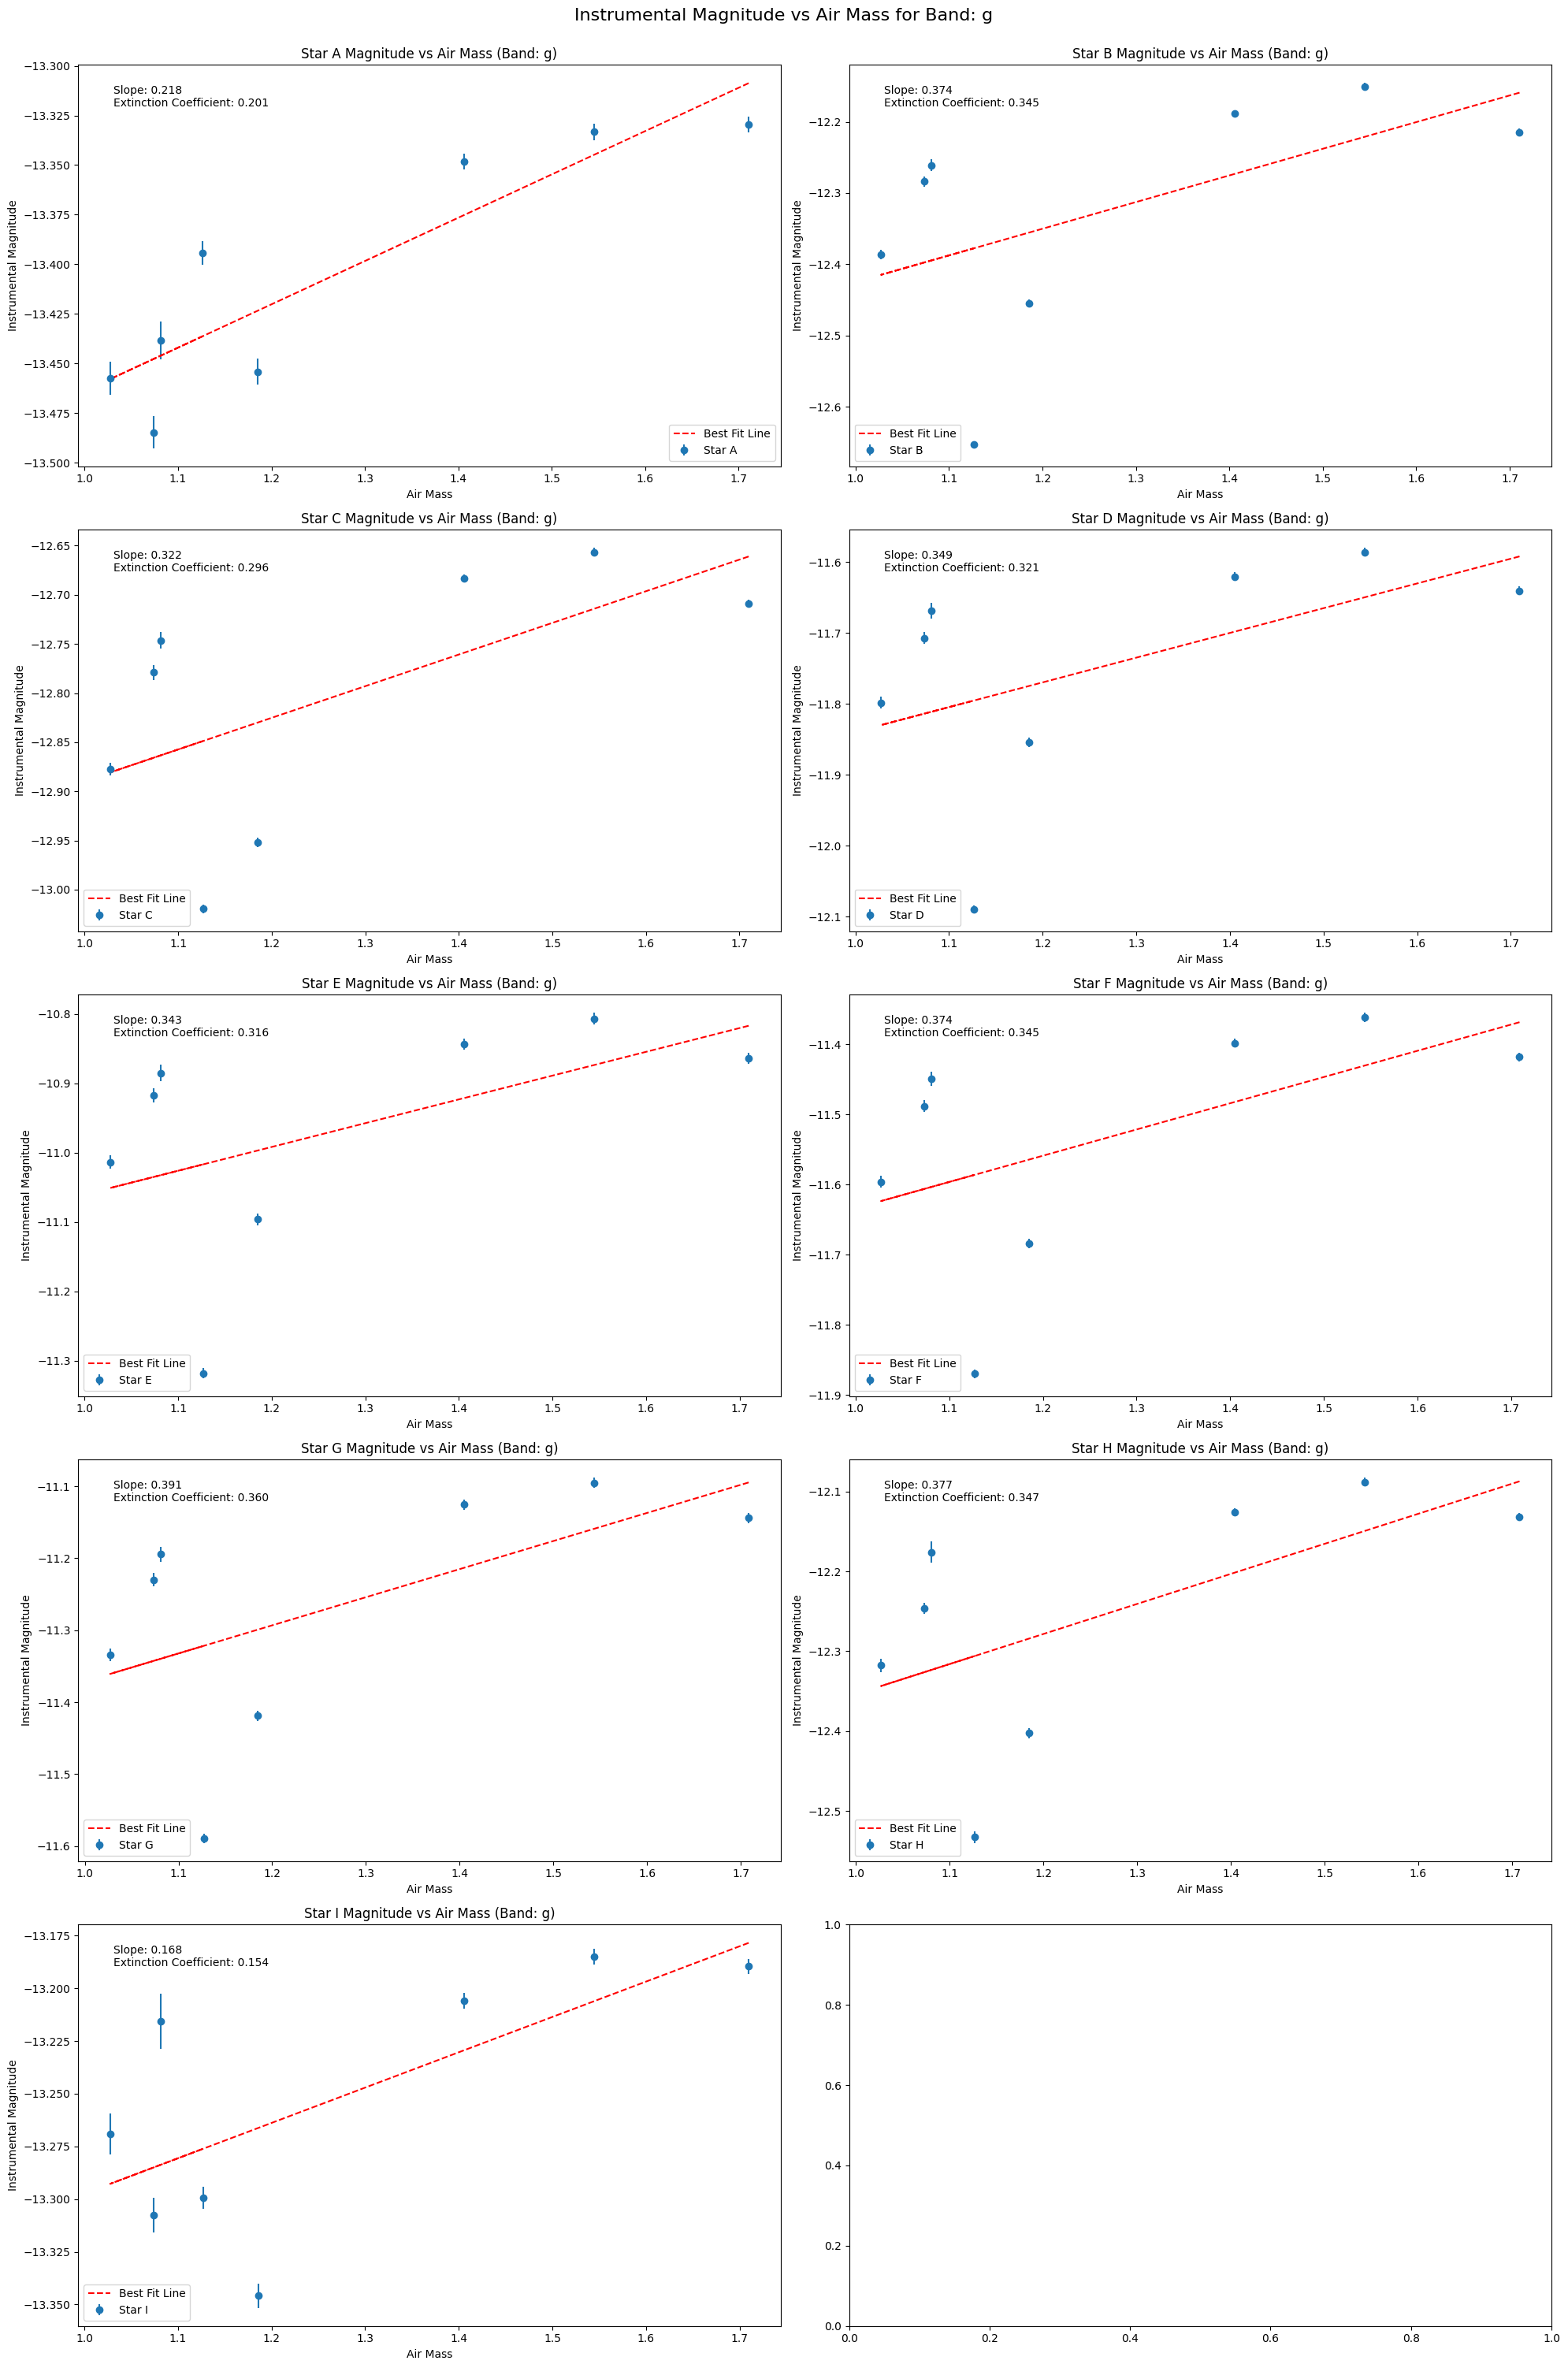

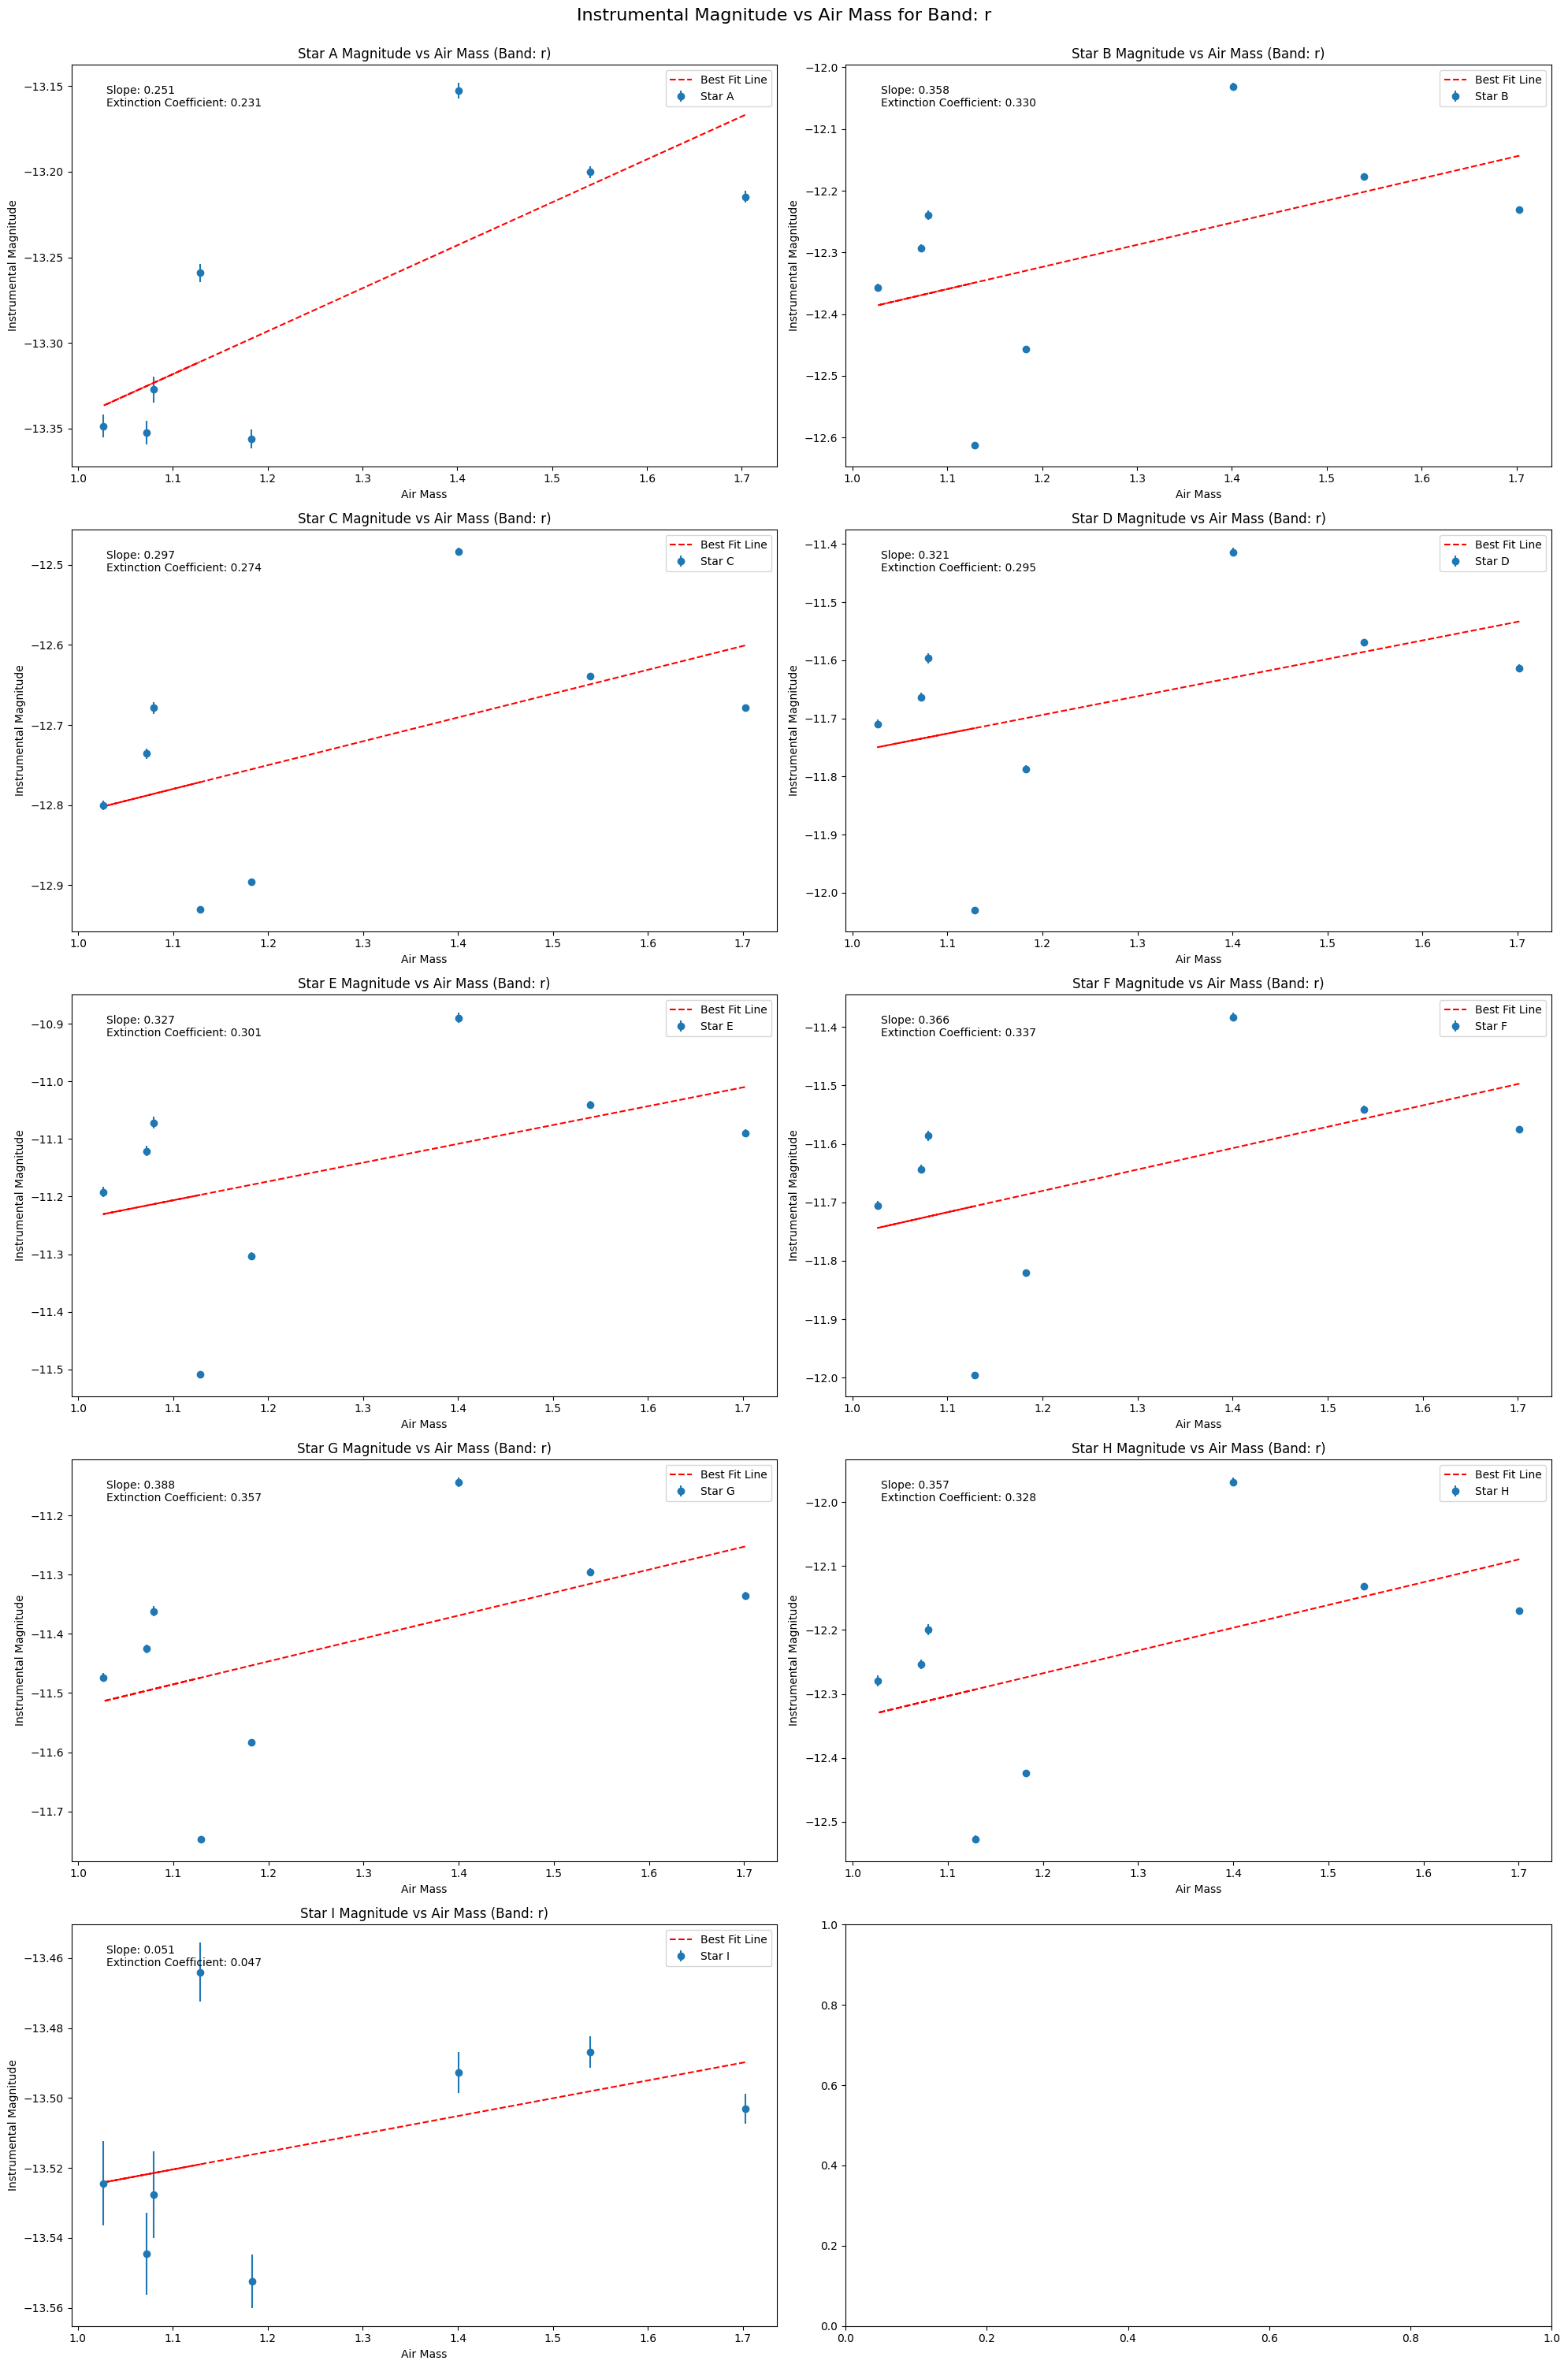

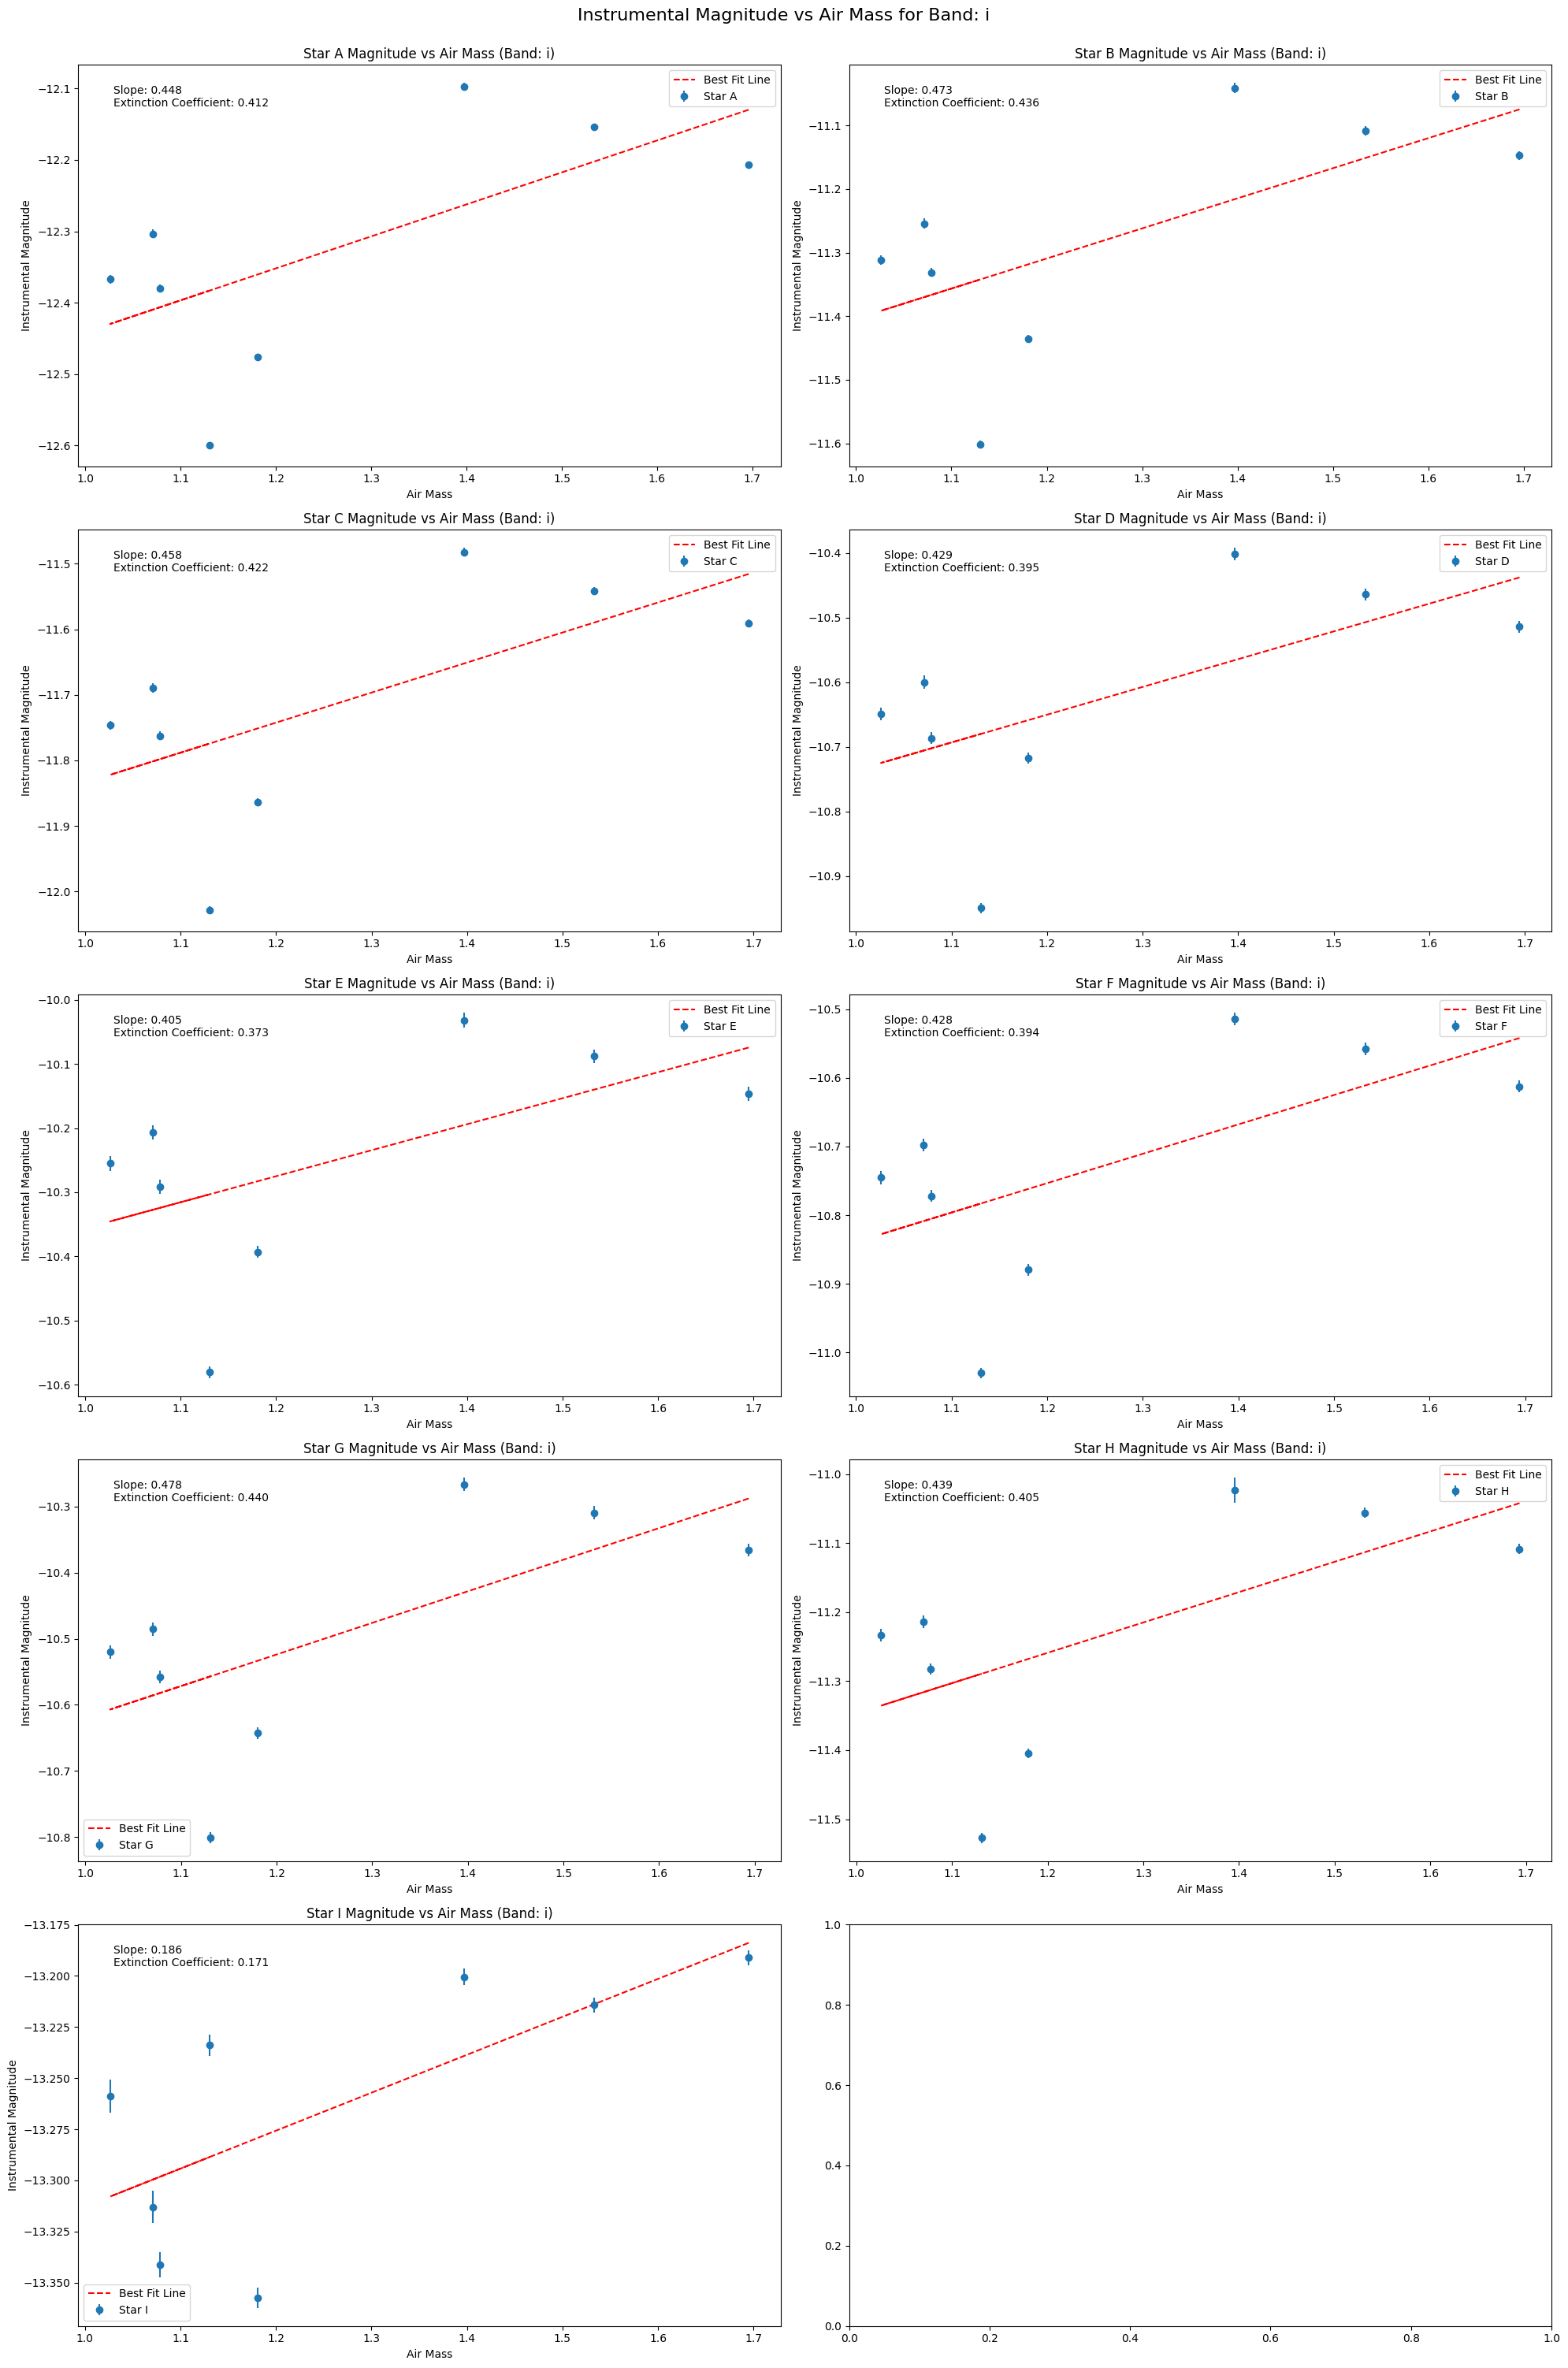

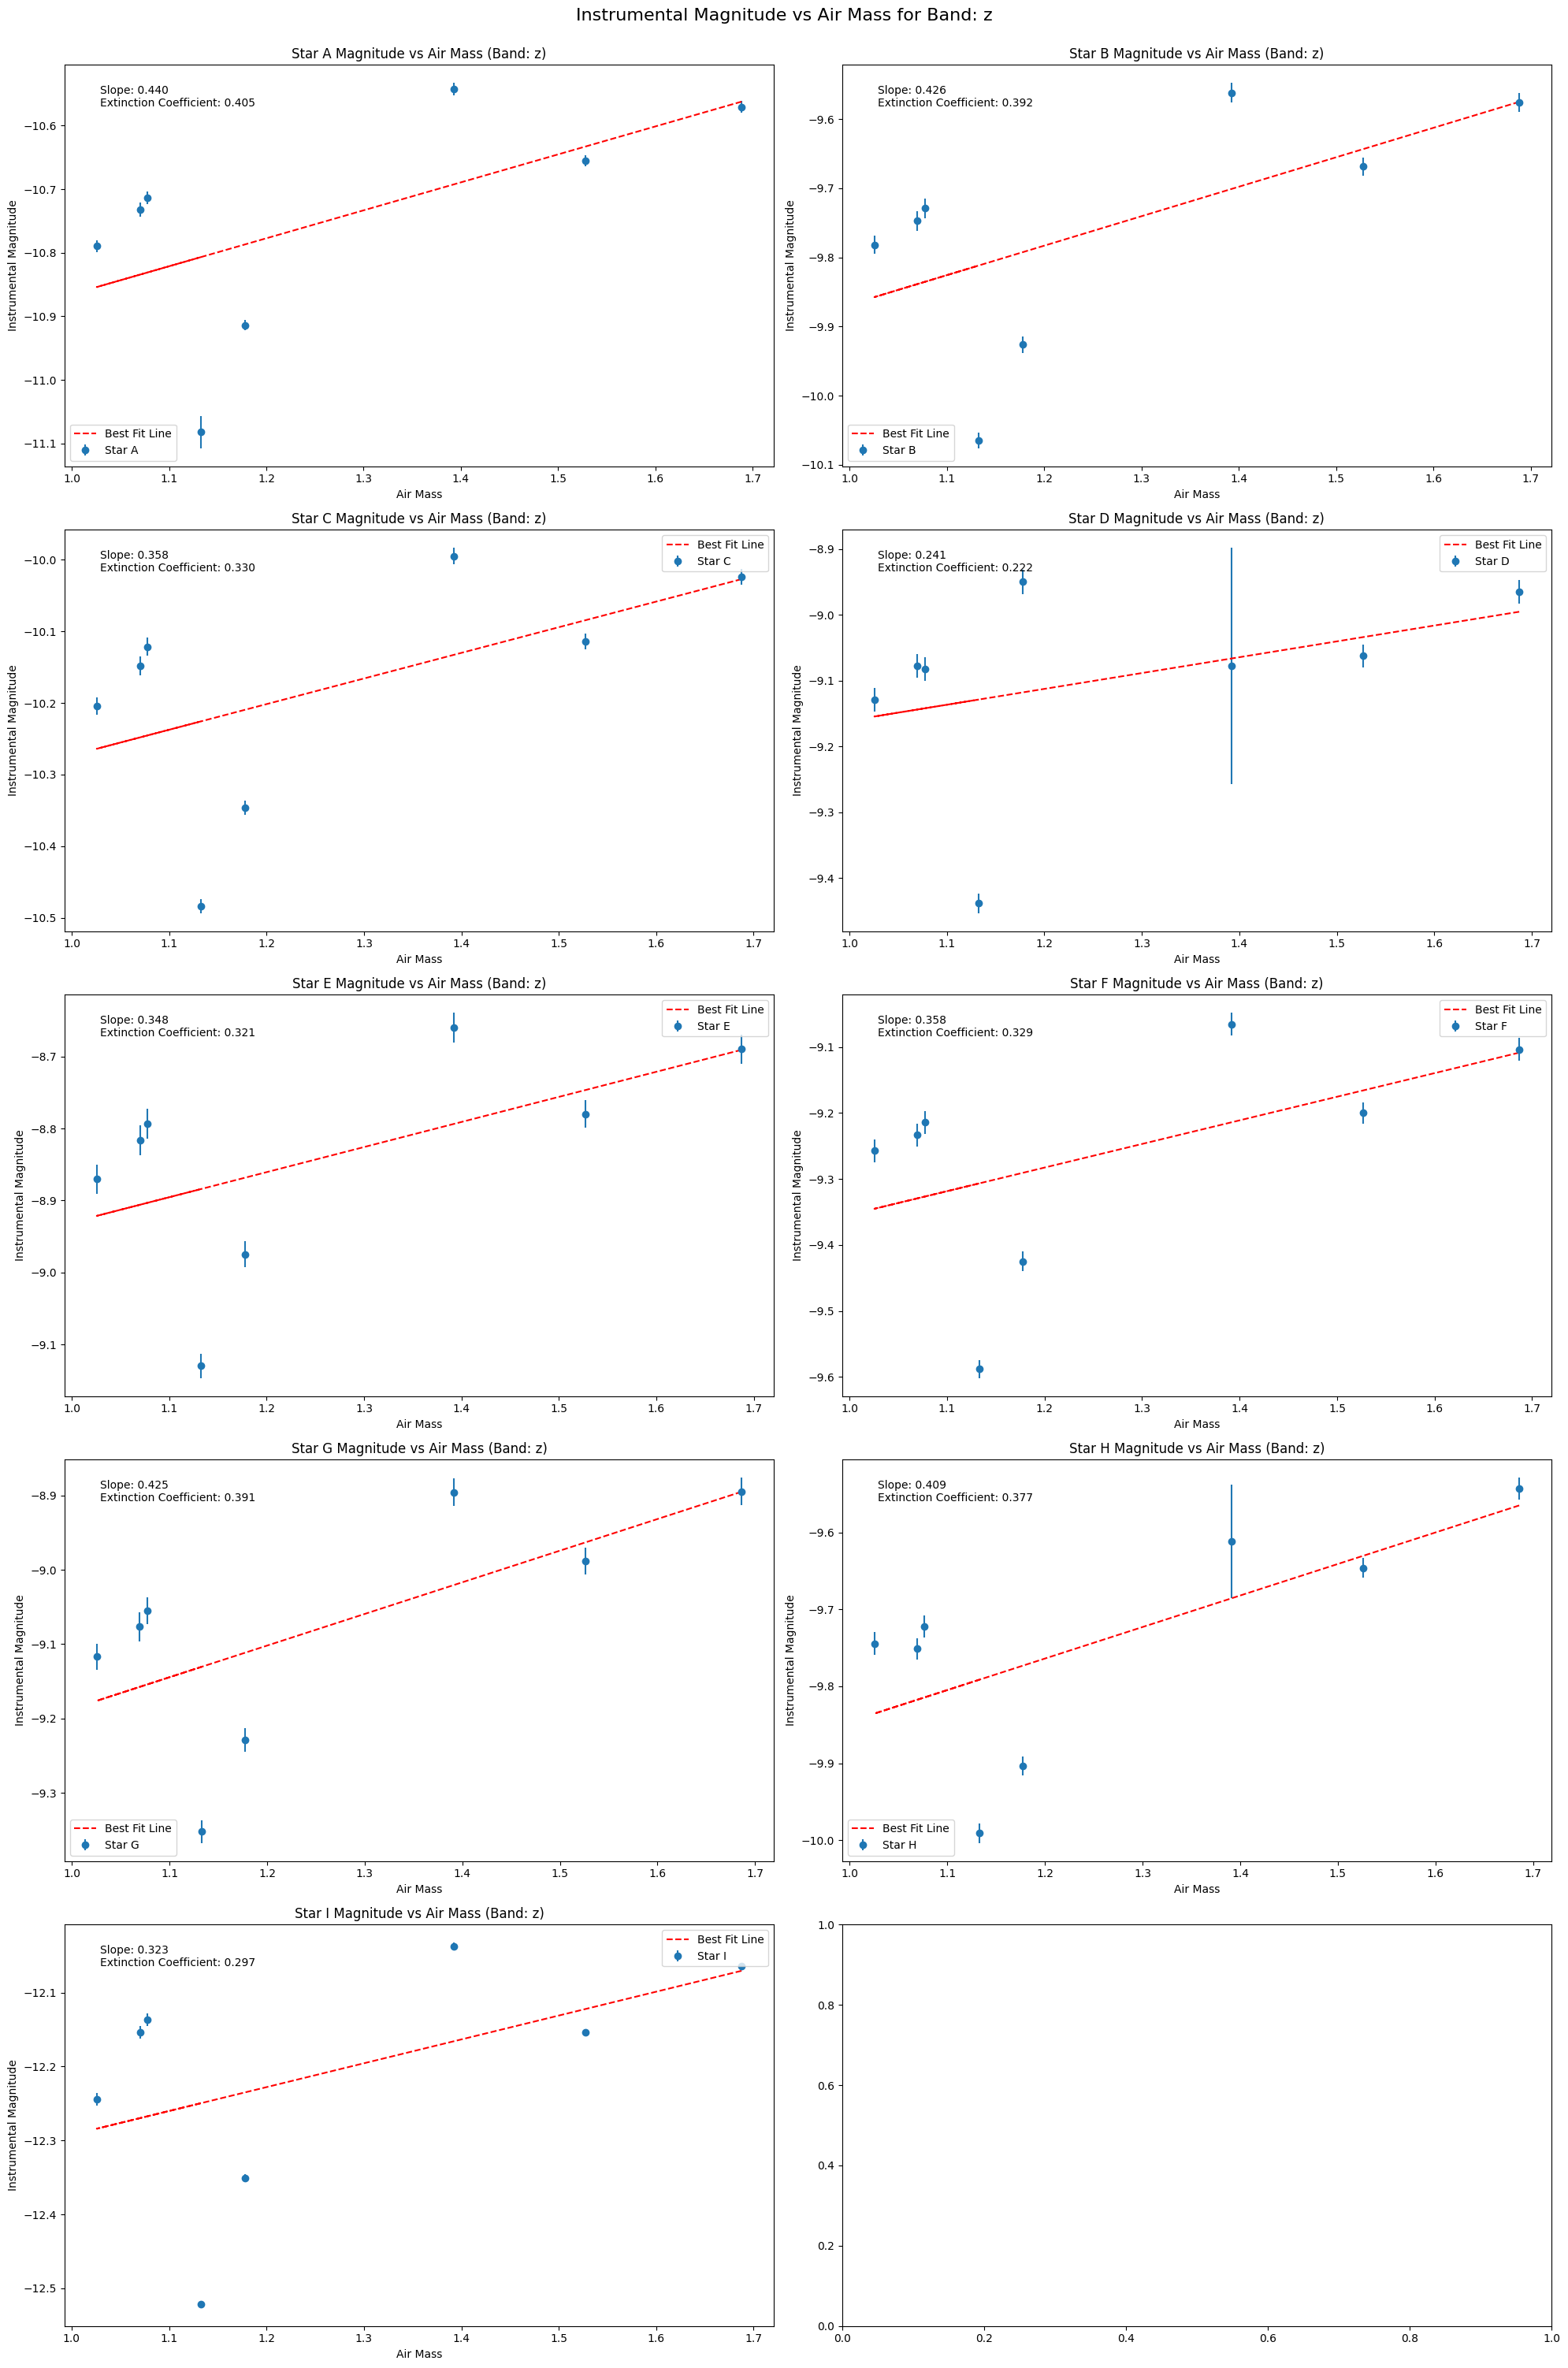

In [21]:
Extinction_Coefficients = { 'u': [], 'g': [], 'r': [], 'i': [], 'z': [] }


for Band in ['u','g', 'r', 'i', 'z']:
    fig, axs = plt.subplots(len(stars) // 2 + 1 , 2, figsize=(20,30))
    fig.suptitle(f'Instrumental Magnitude vs Air Mass for Band: {Band}', fontsize=16, y=1)

    for i, star in enumerate(stars):
        p = np.polyfit(star.air_masses[Band], star.magnitudes[Band], 1)
        axs[i // 2, i % 2].errorbar(star.air_masses[Band], star.magnitudes[Band], yerr=star.del_mags[Band], fmt='o', label=f'Star {star.star_id}')
        axs[i // 2, i % 2].plot(star.air_masses[Band], np.polyval(p, star.air_masses[Band]), 'r--', label='Best Fit Line')
        axs[i // 2, i % 2].set_xlabel('Air Mass')
        axs[i // 2, i % 2].set_ylabel('Instrumental Magnitude')
        # axs[i].invert_yaxis()
        axs[i // 2, i % 2].set_title(f'Star {star.star_id} Magnitude vs Air Mass (Band: {Band})')
        axs[i // 2, i % 2].text(0.05, 0.95, f'Slope: {p[0]:.3f}\nExtinction Coefficient: {p[0]/1.086:.3f}', transform=axs[i // 2, i % 2].transAxes, verticalalignment='top')
        axs[i // 2, i % 2].legend()
        Extinction_Coefficients[Band].append(p[0]/1.086)
    plt.tight_layout()
    plt.show()


In [22]:
print("Extinction Coefficients:")
for band, coeffs in Extinction_Coefficients.items():
    avg_coeff = np.mean(coeffs)
    std_coeff = np.std(coeffs)
    print(f"Band {band}: Average Extinction Coefficient = {avg_coeff:.3f}, Std Dev = {std_coeff:.3f}")

Extinction Coefficients:
Band u: Average Extinction Coefficient = 0.446, Std Dev = 0.022
Band g: Average Extinction Coefficient = 0.298, Std Dev = 0.068
Band r: Average Extinction Coefficient = 0.278, Std Dev = 0.089
Band i: Average Extinction Coefficient = 0.383, Std Dev = 0.078
Band z: Average Extinction Coefficient = 0.340, Std Dev = 0.055


In [23]:
#Averaging for an altitude

alt_indices = data['index'].unique()
# print(alt_indices.dtype)

avg_altitudes = {'u' : [], 'g' : [], 'r': [], 'i': [], 'z': []}
avg_fluxes = {'u' : [], 'g' : [], 'r': [], 'i': [], 'z': []}
avg_del_fluxes = {'u' : [], 'g' : [], 'r': [], 'i': [], 'z': []}

for indice in alt_indices:
    altitudes, fluxes, del_fluxes = [], [], []
    band = ''
    for _, row in data.iterrows():
        if row['index'] == indice:
            altitudes.append(float(row['alt_deg']))
            fluxes.append(float(row['flux']))
            del_fluxes.append(float(row['flux_err']))
            band = row['filter']

    avg_altitudes[band].append(np.mean(altitudes))
    avg_fluxes[band].append(np.mean(fluxes))
    avg_del_fluxes[band].append(np.mean(del_fluxes))

print("Average Altitudes:", avg_altitudes)
print("Average Fluxes:", avg_fluxes)
print("Average Delta Fluxes:", avg_del_fluxes)


Average Altitudes: {'u': [35.537374582046894, 40.10893509496433, 45.120951599886794, 57.27224747093308, 67.39372296154916, 76.58459326652553, 68.39622472006218, 62.82576330339254], 'g': [35.80169719923194, 40.35277779505428, 45.36736132848304, 57.537739837678956, 67.65262060272067, 68.6522566229628, 76.76866488419816, 62.56114763115269], 'r': [35.98002551986608, 40.533499001411045, 45.54994992670385, 57.72382499091249, 67.82676845290355, 68.84446433990105, 76.91383478584291, 62.35947607507593], 'i': [36.16143487755124, 40.71430163007253, 45.73563522565086, 57.90680472771765, 68.00348632233322, 69.01904584362384, 77.04229832874402, 62.1757176077202], 'z': [36.34592963250065, 40.89820007053878, 45.921373338380235, 58.09277579830632, 68.17985948329267, 69.19322145896776, 77.1809693599863, 61.988807627705505]}
Average Fluxes: {'u': [2269.938890500174, 2329.896885115966, 2574.286870552683, 2562.0353495362515, 2458.4037823673507, 3026.0246520714663, 2975.082676758838, 3934.6279113845903], 'g

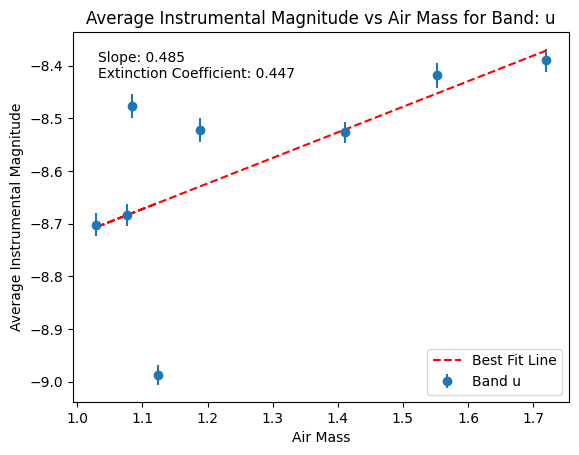

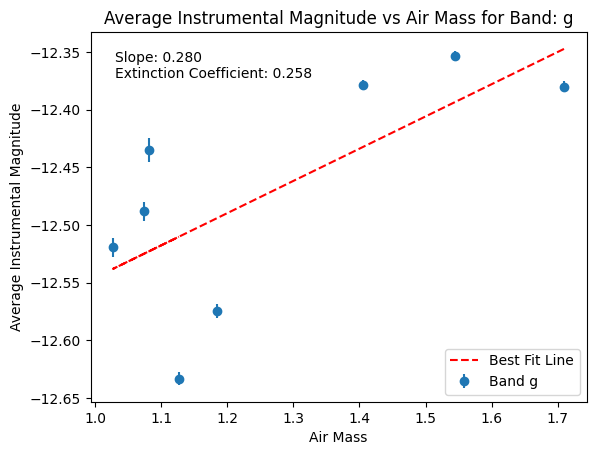

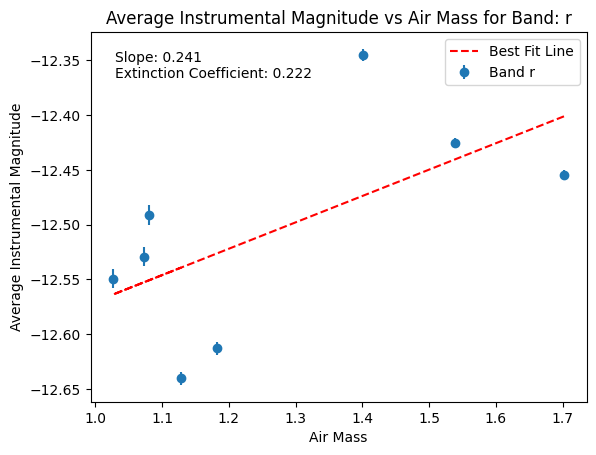

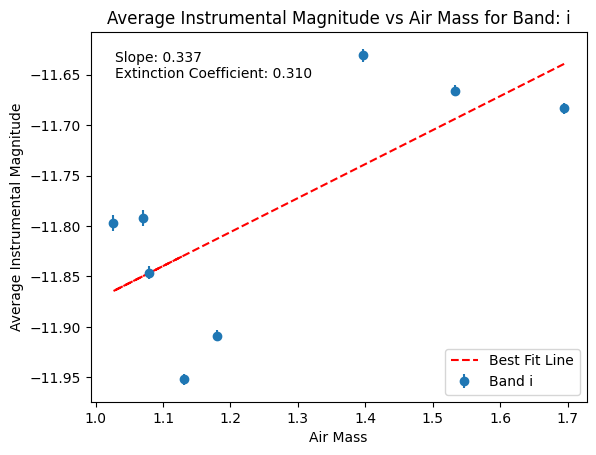

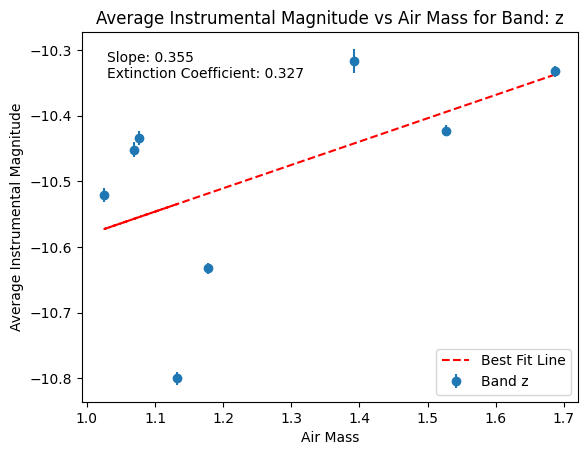

Extinction Coefficients from Averages:
Band u: Average Extinction Coefficient = 0.447
Band g: Average Extinction Coefficient = 0.258
Band r: Average Extinction Coefficient = 0.222
Band i: Average Extinction Coefficient = 0.310
Band z: Average Extinction Coefficient = 0.327


In [24]:
Avg_mag, Avg_mag_err, Avg_airmass = { 'u': [], 'g' : [], 'r': [], 'i': [], 'z': []}, { 'u': [], 'g' : [], 'r': [], 'i': [], 'z': []}, { 'u': [], 'g' : [], 'r': [], 'i': [], 'z': []}
for band in ['u', 'g', 'r', 'i', 'z']:
    for flux, del_flux, alt in zip(avg_fluxes[band], avg_del_fluxes[band], avg_altitudes[band]):
        mag = -2.5 * np.log10(flux)
        mag_err = 1.0857 * (del_flux / flux)
        airmass = 1/np.sin(np.radians(alt))
        Avg_mag[band].append(mag)
        Avg_mag_err[band].append(mag_err)
        Avg_airmass[band].append(airmass)

Extinction_Coefficients_Avg = {'u': [], 'g': [], 'r': [], 'i': [], 'z': [] }
Err_Extinction_Coefficients_Avg = { 'u': [], 'g': [], 'r': [], 'i': [], 'z': [] }

for band in ['u', 'g', 'r', 'i', 'z']:
    plt.errorbar(Avg_airmass[band], Avg_mag[band], yerr=Avg_mag_err[band], fmt='o', label=f'Band {band}')
    p = np.polyfit(Avg_airmass[band], Avg_mag[band], 1)
    plt.plot(Avg_airmass[band], np.polyval(p, Avg_airmass[band]), 'r--', label='Best Fit Line')
    plt.xlabel('Air Mass')
    plt.ylabel('Average Instrumental Magnitude')
    plt.title(f'Average Instrumental Magnitude vs Air Mass for Band: {band}')
    # plt.gca().invert_yaxis()
    plt.text(0.05, 0.95, f'Slope: {p[0]:.3f}\nExtinction Coefficient: {p[0]/1.086:.3f}', transform=plt.gca().transAxes, verticalalignment='top')
    plt.legend()
    plt.show()
    Extinction_Coefficients_Avg[band].append(p[0]/1.086)

print("Extinction Coefficients from Averages:")
for band, coeffs in Extinction_Coefficients_Avg.items():
    avg_coeff = np.mean(coeffs)
    print(f"Band {band}: Average Extinction Coefficient = {avg_coeff:.3f}")